# Sleep Apnea Detection

This project was part of the Machine Learning Health Technology Project course in University of Turku. 

Data was given along with the assignment and it includes a single channel ECG signal measured during sleep. 

- Sampling rate is 100hz and samples are 30 seconds long.
- Objective of the project was to create a model that can detect sleep apnea using HRV features extracted from ECG data. 
> Sleep apnea is a medical condition where the person suffers from intermittent breathing cessations during sleep. It's correlated with increased mortality rate, myocardial infarctions, and increased blood pressure.


In [1]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import neurokit2 as nk

from pathlib import Path
import matplotlib.pyplot as plt

## Data loading

We begin by first globbing and reading the data from text files. We do this by writing a simple read_txt function that we use to iterate through the lists.

We begin by reading the ECG signals from .txt files using a custom read_txt function and glob.
Normal and Apnea signals are separated in their own directories.

In [2]:
datadir = Path("data")

apnea_train = list((datadir / "Train/apnea").glob("*.txt"))
normal_train = list((datadir / "Train/normal").glob("*.txt"))
apnea_test = list((datadir / "Test/apnea").glob("*.txt"))
normal_test = list((datadir / "Test/normal").glob("*.txt"))

def read_txt(data):
    signals = []
    for i in data:
        df = pd.read_csv(i, header=None)
        signals.append(df.squeeze())
    return signals

apnea_train = read_txt(apnea_train)
normal_train = read_txt(normal_train)
apnea_test = read_txt(apnea_test)
normal_test = read_txt(normal_test)


## Filtering & Peak detection

We apply a Butterworth band-pass filter (0.5-40 Hz) to remove baseline wandering and high frequency noise. We're also utilizing neurokit2's ecg_peaks to locate R-peaks in the filtered signals.

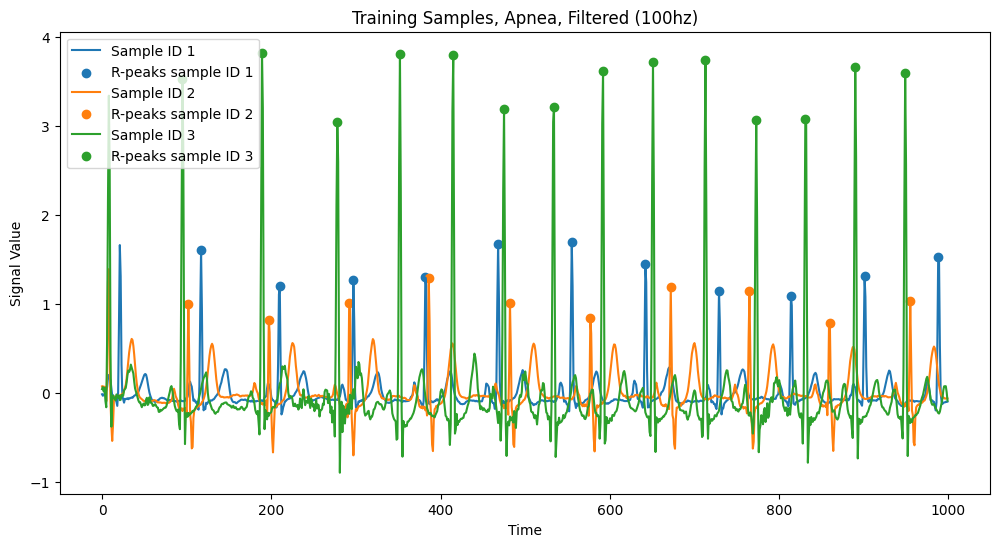

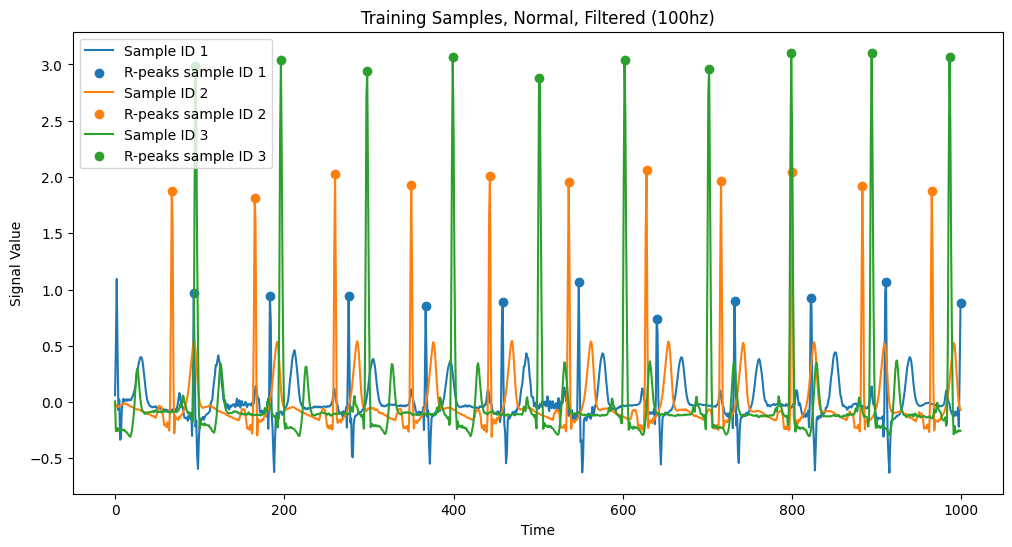

In [3]:
def butter_bandpass(signal, lowcut=0.5, highcut=40.0, fs=100, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def find_peaks(filtered_signal):
    r_peaks_list = []
    for signal in filtered_signal:
        _, rpeaks = nk.ecg_peaks(signal, sampling_rate=100)
        r_peaks_list.append(rpeaks["ECG_R_Peaks"])
    return r_peaks_list

def plot_signals(signals, peaks_list, title, n=3):
    plt.figure(figsize=(12, 6))
    for i in range(min(n, len(signals))):
        plt.plot(signals[i][:1000], label=f"Sample ID {i+1}")
        p = [idx for idx in peaks_list[i] if idx < 1000]
        plt.scatter(p, signals[i][p], label=f"R-peaks sample ID {i+1}")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.show()

normal_train_filtered = [butter_bandpass(signal) for signal in normal_train]
apnea_train_filtered = [butter_bandpass(signal) for signal in apnea_train]
normal_test_filtered = [butter_bandpass(signal) for signal in normal_test]
apnea_test_filtered = [butter_bandpass(signal) for signal in apnea_test]

normal_train_peaks = find_peaks(normal_train_filtered)
normal_test_peaks = find_peaks(normal_test_filtered)
apnea_train_peaks = find_peaks(apnea_train_filtered)
apnea_test_peaks = find_peaks(apnea_test_filtered)

plot_signals(apnea_train_filtered, apnea_train_peaks, "Training Samples, Apnea, Filtered (100hz)", n=3)
plot_signals(normal_train_filtered, normal_train_peaks, "Training Samples, Normal, Filtered (100hz)", n=3)

Here we check that the neurokit2's hrv method is correctly computing the HRV data for our peaks' data

In [4]:
display(nk.hrv(normal_train_peaks[0], sampling_rate=100))
display(nk.hrv(apnea_train_peaks[0], sampling_rate=100))

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,751.838791,57.083089,41.417579,42.568748,NaN,NaN,NaN,NaN,19.765034,19.787307,...,0.668085,4.250648,0.652821,1.044872,1.158474,1.323673,1.54979,1.613905,2.053097,0.478403


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,875.659824,80.329771,23.511797,77.466564,NaN,NaN,NaN,NaN,22.380401,22.413212,...,0.783805,4.912192,0.525794,1.073954,1.144293,1.800898,1.688271,1.236444,2.231697,0.370101


## Feature extraction

In [5]:
train_hrv_data = []
for peak in normal_train_peaks + apnea_train_peaks:
    HRV_data = nk.hrv(peak, sampling_rate=100)
    train_hrv_data.append(HRV_data.iloc[0])
# features = ['HRV_SDNN','HRV_RMSSD','HRV_pNN50', 'HRV_SDRMSSD', 'HRV_LF', 'HRV_HF','HRV_CVNN']

In [6]:
test_hrv_data = []
for peak in normal_test_peaks + apnea_test_peaks:
    HRV_data = nk.hrv(peak, sampling_rate=100)
    test_hrv_data.append(HRV_data.iloc[0])

Here we do the features and labels for our models' data. We label normal ECGs with 0 and apnea ECGs with 1. After creating the model data we standardize it.

In [7]:
X_train = pd.DataFrame(train_hrv_data)
y_train = np.array([0] * len(normal_train) + [1] * len(apnea_train))
X_test = pd.DataFrame(test_hrv_data)
y_test = np.array([0] * len(normal_test) + [1] * len(apnea_test))

In [8]:
from sklearn.preprocessing import StandardScaler

X_train = X_train.dropna(axis=1)
X_test = X_test[X_train.columns]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
np.bincount(y_train)

array([331, 293])

## Modeling

We chose two tree-based classifiers: RandomForest and XGBClassifier and tuned them with GridSearch with 5-fold CV on the training set. All features were standardized using StandardScaler

### Baseline
Baseline we can use to compare our selected models

In [10]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Baseline:\n", classification_report(y_test, y_pred_dummy, zero_division=True))
dummy.score(X_test_scaled, y_test)

Baseline:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68        81
           1       1.00      0.00      0.00        75

    accuracy                           0.52       156
   macro avg       0.76      0.50      0.34       156
weighted avg       0.75      0.52      0.35       156



0.5192307692307693

### RandomForest

We run GridSearch to find the best hyperparameters. 

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid,
                       cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
rf_grid.fit(X_train_scaled, y_train)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF Accuracy:", rf_grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total

We chose the hyperparameters the GridSearch recommended and computed the score which turned out to be around 0.82.

In [12]:

forest = rf_grid.best_estimator_
y_pred_forest = forest.predict(X_test_scaled)

print("\n", forest.score(X_test_scaled, y_test))


 0.8205128205128205


### XGBoost

We're comparing RandomForest to XGBoost by doing the same procedure starting with GridSearch to find the best hyperparameters.

In [13]:
from xgboost import XGBClassifier

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,4,5],
    'learning_rate': [0.2, 0.05, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid,
                        cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
xgb_grid.fit(X_train_scaled, y_train)

print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB Accuracy:", xgb_grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsampl

And finally computing the score for XGBoost as well. XGBoost got a slightly worse score of 0.78.

In [14]:
xgb = xgb_grid.best_estimator_
y_pred_xgb = xgb.predict(X_test_scaled)

print(xgb.score(X_test_scaled, y_test))

0.7756410256410257


### Evaluation
Performance was evaluated using Accuracy, Precision, Recall, F1-score and ROC+AUC

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
forest_classification = classification_report(y_test, y_pred_forest)
forest_confusion = confusion_matrix(y_test, y_pred_forest)
xgb_classification = classification_report(y_test, y_pred_xgb)
xgb_confusion = confusion_matrix(y_test, y_pred_xgb)

Here is a plot for the Confusion Matrices.

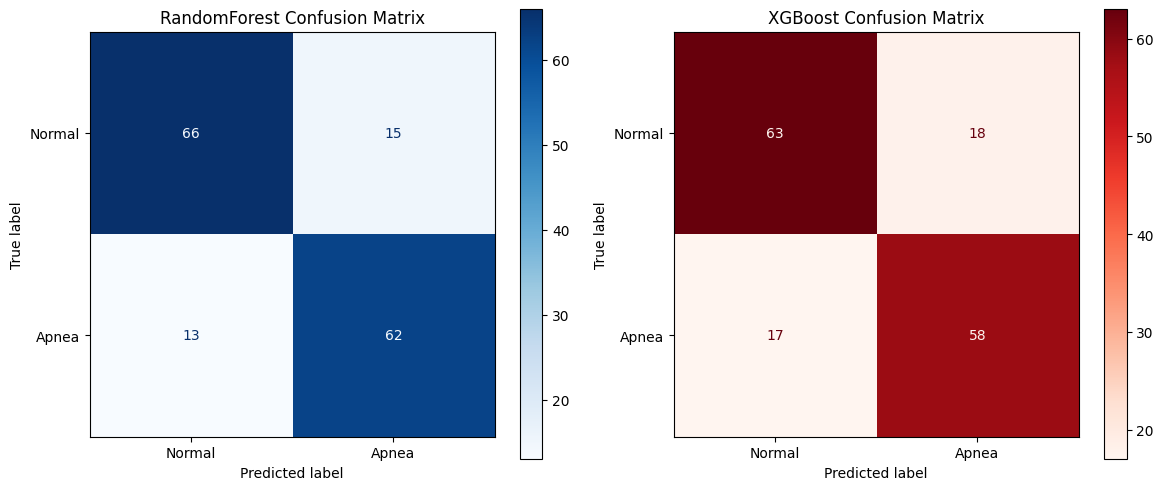

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(forest_confusion, display_labels=['Normal', 'Apnea']).plot(ax=axs[0], cmap='Blues')
axs[0].set_title('RandomForest Confusion Matrix')

ConfusionMatrixDisplay(xgb_confusion, display_labels=['Normal', 'Apnea']).plot(ax=axs[1], cmap='Reds')
axs[1].set_title('XGBoost Confusion Matrix')

plt.tight_layout()
plt.show()

Here are the classification reports' stats.

In [17]:
print(forest_classification)
print(xgb_classification)

              precision    recall  f1-score   support

           0       0.84      0.81      0.82        81
           1       0.81      0.83      0.82        75

    accuracy                           0.82       156
   macro avg       0.82      0.82      0.82       156
weighted avg       0.82      0.82      0.82       156

              precision    recall  f1-score   support

           0       0.79      0.78      0.78        81
           1       0.76      0.77      0.77        75

    accuracy                           0.78       156
   macro avg       0.78      0.78      0.78       156
weighted avg       0.78      0.78      0.78       156



Finally, let's plot the ROC Curve for both models.

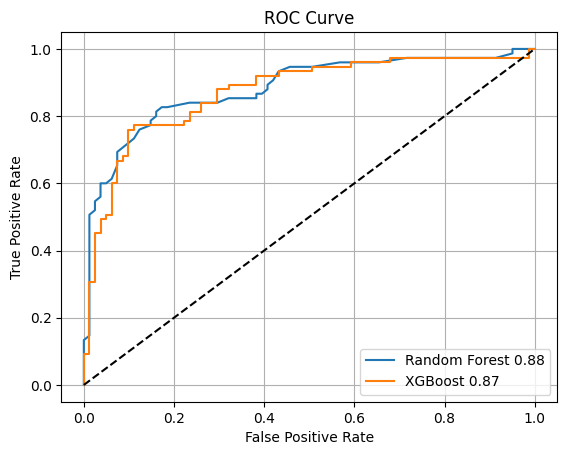

In [18]:
from sklearn.metrics import roc_curve, auc

rf_probs = forest.predict_proba(X_test_scaled)[:, 1]
xgb_probs = xgb.predict_proba(X_test_scaled)[:, 1]

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.plot(rf_fpr, rf_tpr, label=f'Random Forest {rf_auc:.2f}')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost {xgb_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion

| Model         | Accuracy | F1 (Apnea) | ROC-AUC |
|---------------|----------|------------|---------|
| Dummy (majority) | 0.52 | 0.00 | 0.50 |
| RandomForest  | **0.82** | **0.82** | **0.88** |
| XGBoost       | 0.782 | 0.78 | 0.87 |

When detecting sleep apnea with this data set, we can see that RandomForest is performing better. Data got filtered using Butterworth band-pass and ECG got handled using neurokit2's methods. After adjusting the selected HRV features to be used with the models we found that involving neurokit2's HRV method's all features brought the best results.